In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import warnings
warnings.filterwarnings("ignore")

In [2]:
from torchvision import datasets, transforms

In [3]:
# download and transform train dataset
train_loader = torch.utils.data.DataLoader(datasets.MNIST('mnist', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=64, 
                                           shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(datasets.MNIST('mnist', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=64, 
                                           shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [5]:
# define classification model
class ModelMNIST(nn.Module):
    def __init__(self, out_size=10):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(kernel_size=4, stride=2, padding=2),

            nn.Dropout(p=0.25),

            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=3, padding=1),

            nn.Dropout(p=0.25),
            nn.Flatten()
        )

        self.linear_layers = nn.Sequential(
            nn.BatchNorm1d(num_features=1600),
            nn.Linear(1600, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, out_size)
        )

    def forward(self, input_batch):
        conv_output = self.conv_layers(input_batch)
        logits = self.linear_layers(conv_output)
        return logits

In [6]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
n_epochs = 10

In [7]:
from IPython.display import clear_output

model = ModelMNIST().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=0.005)

losses = []


loss: 0.08045983


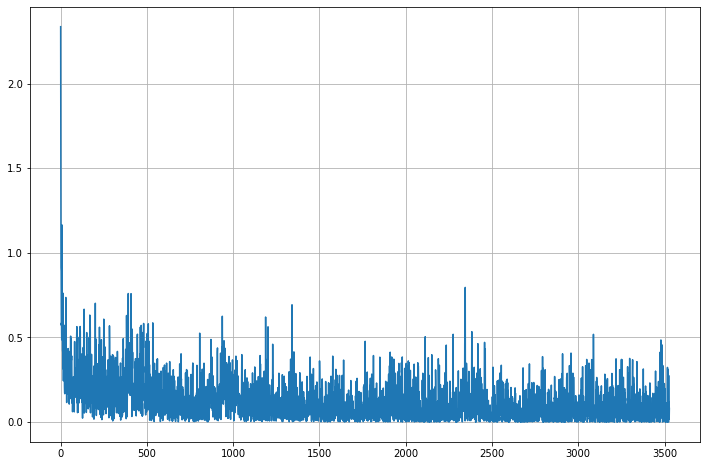

In [12]:
# training
for _ in range(15):
    for i, batch in enumerate(train_loader):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        y_pred = model(x_batch)
        loss = torch.nn.functional.cross_entropy(y_pred, y_batch.long())
        loss.backward()

        opt.step()

        opt.zero_grad()

        if (i + 5) % 5 == 0:
            clear_output(True)
            losses.append(loss.cpu().detach().numpy())
            print("loss:", loss.cpu().detach().numpy())
            plt.figure(figsize=(12, 8))
            plt.plot(losses)
            plt.grid()
            plt.show()

In [13]:
#evaluating
test_losses = []
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.to(DEVICE), target.to(DEVICE)
    output = model(data)
    test_loss += F.nll_loss(output, target, size_average=False).item()
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
test_loss /= len(test_loader.dataset)
test_losses.append(test_loss)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  test_loss, correct, len(test_loader.dataset),
  100. * correct / len(test_loader.dataset)))


Test set: Avg. loss: -28.2281, Accuracy: 9767/10000 (98%)

